# 환경 설정

In [1]:
import matplotlib.pyplot as plt 
# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기

In [ ]:
import pandas as pd

train = pd.read_csv("data/train.csv")
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


# 머신러닝 vs 딥러닝 코드 흐름도
- 데이터 수집
- 반복
    + 데이터 가공 (e.g. 모든 데이터 숫자로 변형)
    + (동시) 탐색적 자료 분석 (ML에서는 매우 중요한 과정, DL에서는 옵션(안해도 됨))
    + 훈련 데이터 / (검증 데이터) / 테스트 데이터 분리
    + 모델링 코드 구현
    + 평가지표
- 평가지표가 가장 좋은 모델 선정 ==> ML/DL 서비스 구현

# 탐색적 자료 분석 (정형 데이터를 활용할 때만 필요)
- 기초통계, 시각화를 최대한 활용
- 궁극적인 목표 : 수많은 변수 중에서 쓸모있는 변수를 가려내는 것

## 기초 통계 및 데이터 구조 파악
- 각 변수의 분포, 결측치, 이상치 확인
- 변수별 요약 통계량 분석

In [3]:
# 데이터 기본 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [4]:
# 수치형 변수들의 기초 통계량
train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [5]:
# 범주형 변수(Sex) 분포 확인
train['Sex'].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

In [6]:
# 결측치 확인
train.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

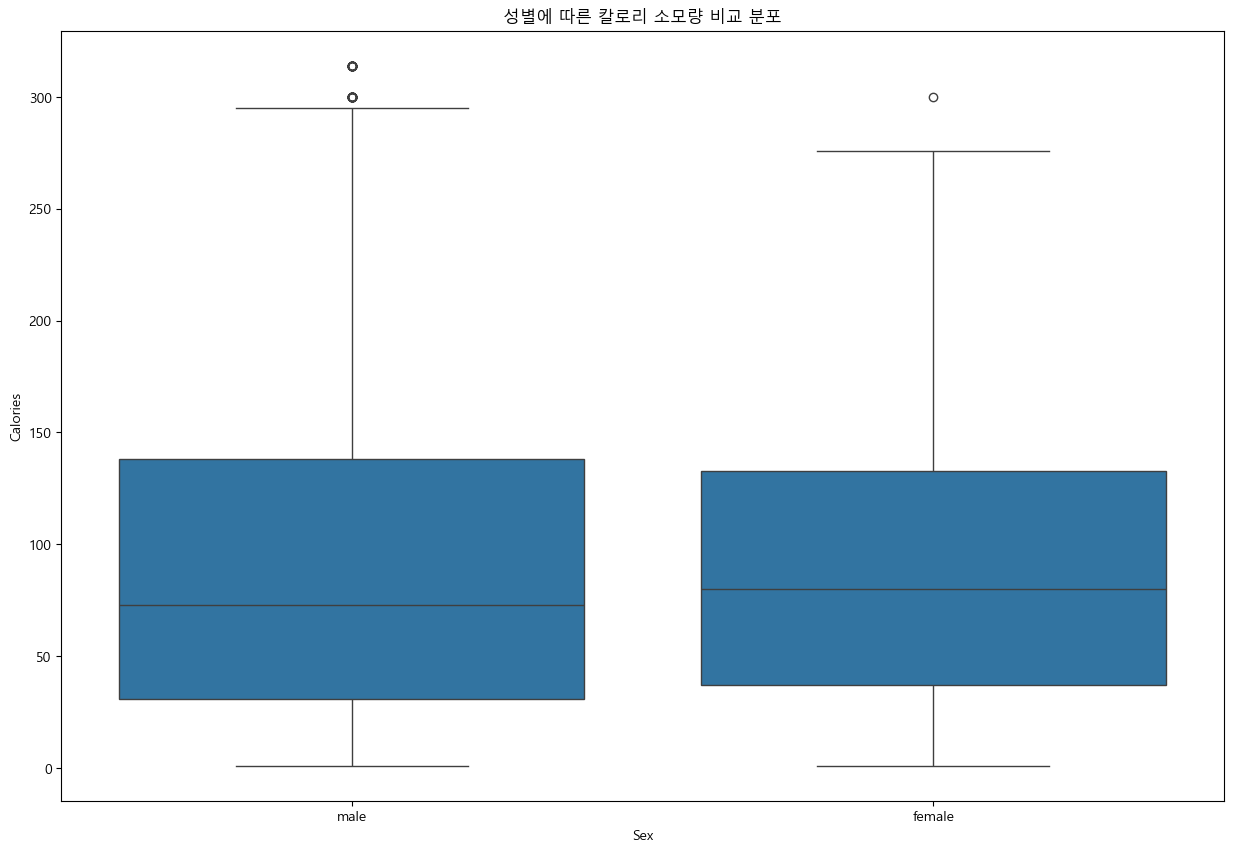

In [7]:
# 이상치 탐색
# 통계 : 독립변수, 종속변수
# ML/DL : 독립변수, Target (=Calories)

import matplotlib.pyplot as plt
import seaborn as sns

train2 = train.copy()
# id를 왜 바로 지워야 할까?
# 패턴(규칙)이 발견될만한 것이 존재하지 않음.
train2 = train2.drop('id', axis=1) 
train2.head()

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data = train2, x = 'Sex', y = 'Calories', ax = ax)
ax.set_title('성별에 따른 칼로리 소모량 비교 분포')
plt.show()

- 첫번째 질문 : 평균 비교
- 두번째 질문 : 통계적으로 유의한가?
  + 두 평균의 비교 : 정규성 검증, 등분산성 검정, 코드 처리
- 결론: 성별에 따른 칼로리 소모량의 차이가 통계적으로 유의미하다.
- 세번째 질문 : 그래서 어쩌라고?
  + 모델 1 : 성별을 그대로 다 활용하는 방식, 전체 통합 모델 하나 만들기
  + 모델 2 : 성별을 기반으로 데이터 분리하고, 남성모델 예측 / 여성모델 예측 각각 개발

In [8]:
# 가설 검정을 위한 통계적 분석
from scipy import stats

# 각 성별 그룹의 칼로리 데이터
male_calories = train[train['Sex'] == 'male']['Calories']
female_calories = train[train['Sex'] == 'female']['Calories']

# 정규성 검정 (Shapiro-Wilk test)
# 가설설정
# - 귀무가설: 두 표본은 정규분포를 이룬다.
# - 가설설정: 두 표본은 정규분포를 이루지 않는다.
male_normality = stats.shapiro(male_calories)
female_normality = stats.shapiro(female_calories)
# 표본이 5000개가 넘는 374279, 375721개 이므로 경고메시지 나옴.

print("정규성 검정 결과:")
print(f"남성 그룹 - W 통계량: {male_normality[0]:.4f}, p-value: {male_normality[1]:.4f}")
print(f"여성 그룹 - W 통계량: {female_normality[0]:.4f}, p-value: {female_normality[1]:.4f}")

# 등분산성 검정 (Levene's test)
# 가설설정
# - 귀무가설: 두 그룹의 분산은 동일하다.
# - 대립가설: 두 그룹의 분산은 동일하지 않다.
levene_test = stats.levene(male_calories, female_calories)
print("\n등분산성 검정 결과:")
print(f"Levene 통계량: {levene_test[0]:.4f}, p-value: {levene_test[1]:.4f}")

# 독립표본 t-검정 수행
# 가설설정
# - 귀무가설: 두 그룹의 평균은 같다.
# - 대립가설: 두 그룹의 평균은 같지 않다.
t_stat, p_value = stats.ttest_ind(male_calories, female_calories, equal_var=False)
print("\n독립표본 t-검정 결과:")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

정규성 검정 결과:
남성 그룹 - W 통계량: 0.9307, p-value: 0.0000
여성 그룹 - W 통계량: 0.9500, p-value: 0.0000

등분산성 검정 결과:
Levene 통계량: 5275.6445, p-value: 0.0000

독립표본 t-검정 결과:
t-통계량: 10.4002
p-value: 0.0000


C:\Users\Admin\Desktop\ai_statistics\playground-series-s5e5\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 374279.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Admin\Desktop\ai_statistics\playground-series-s5e5\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 375721.
  res = hypotest_fun_out(*samples, **kwds)


### 층화추출 기법 활용
- Sex의 비율대로 층화추출 진행
- 각 샘플의 크기를 Max 4900 정도로 뽑아서 하는 것 추천

Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')


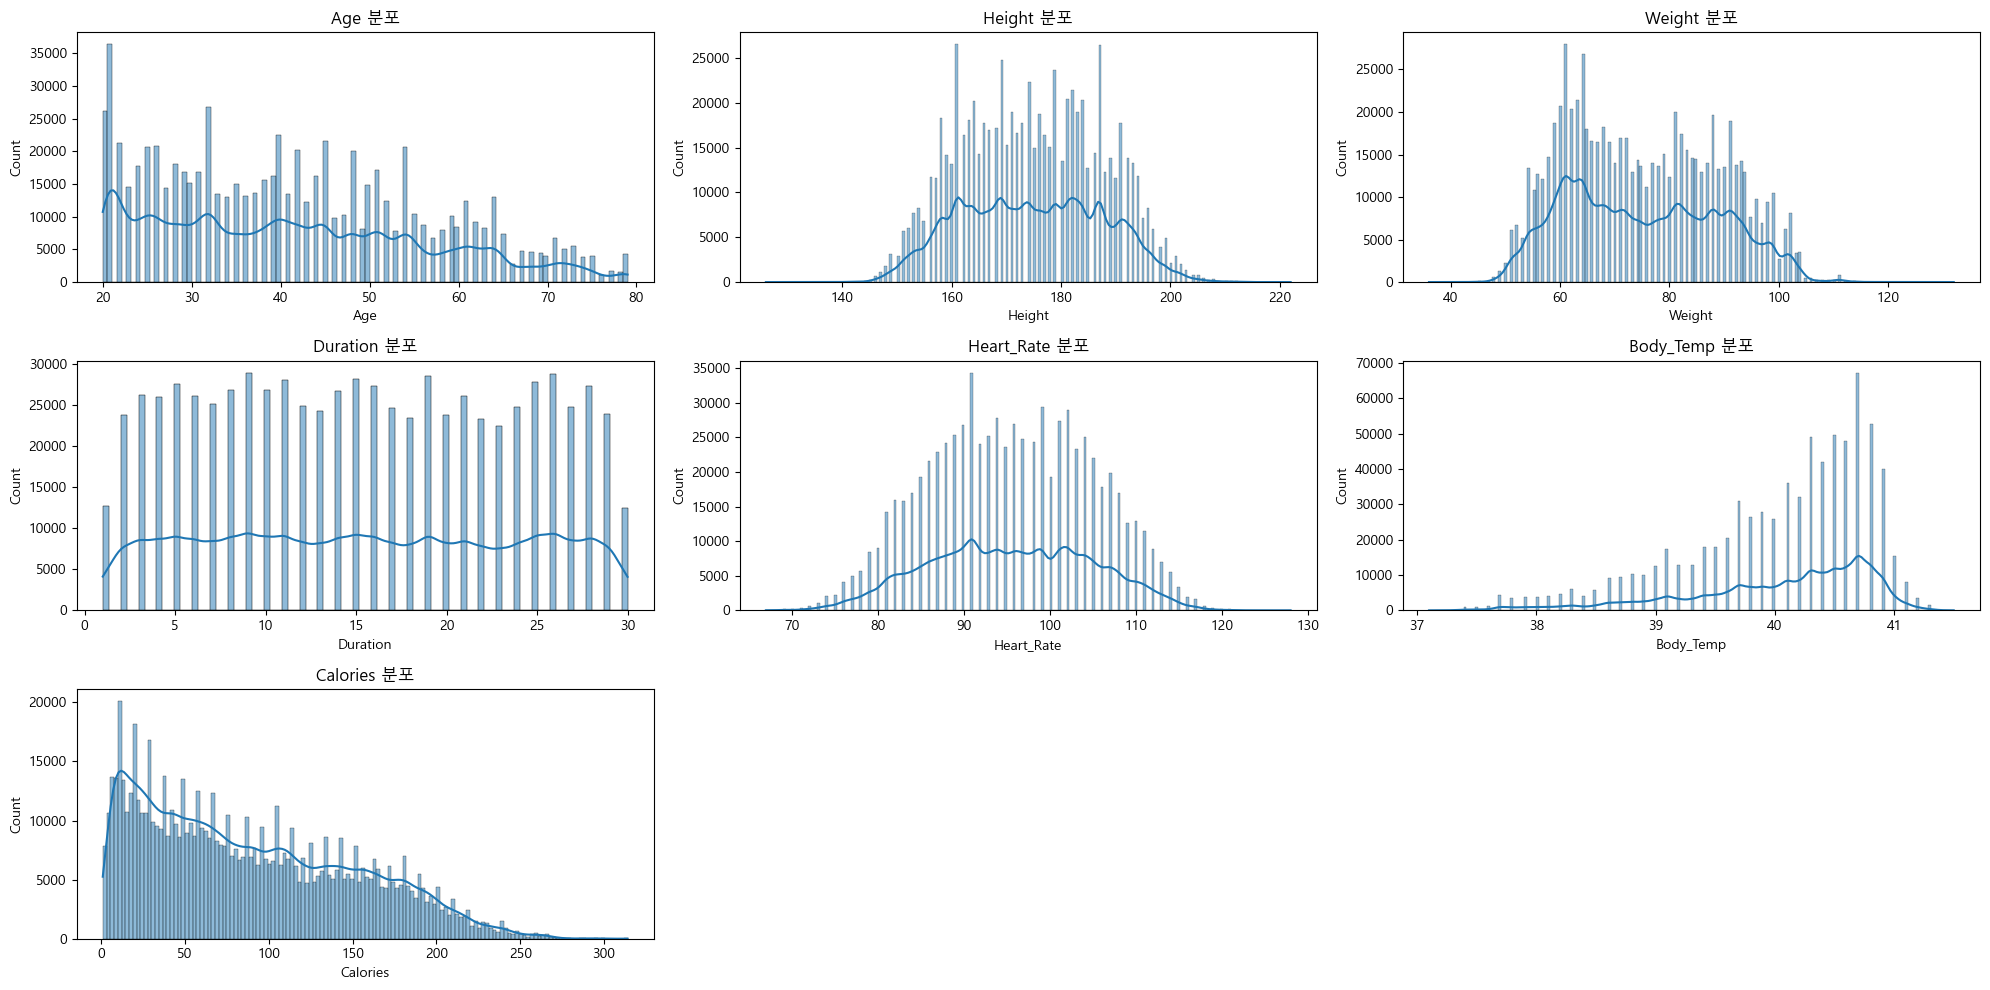

In [9]:
# 수치형 변수들의 분포 확인
numeric_cols = train2.select_dtypes(include=['float64', 'int64']).columns
# numeric_cols = numeric_cols[numeric_cols != 'id'] # id 컬럼 제외
print(numeric_cols)

# # 히스토그램
# fig, ax = plt.subplots()
# sns.histplot(data=train2, x='Age', kde=True)
# ax.set_title('Age 분포')
# plt.show()

# 서브플롯 구성 (2행 4열)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

# 각 컬럼에 대해 히스토그램 + KDE 그리기
for i, col in enumerate(numeric_cols):
    sns.histplot(data=train2, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} 분포')

# 마지막 서브플롯 비우기 (총 7개만 사용)
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

plt.tight_layout()
plt.show()

## 변수 간 관계 탐색
- 두 변수 이상이 반드시 활용이 되어야 함
- 기준점 : 항상 Target 변수가 기준점
  + 타겟 : Calories
  + ??변수가 Calories에 어떤 영향을 주는 건가?
- 통계 방법론: 상관분석, 회귀분석
- 시각화 : 산점도, 히트맵 

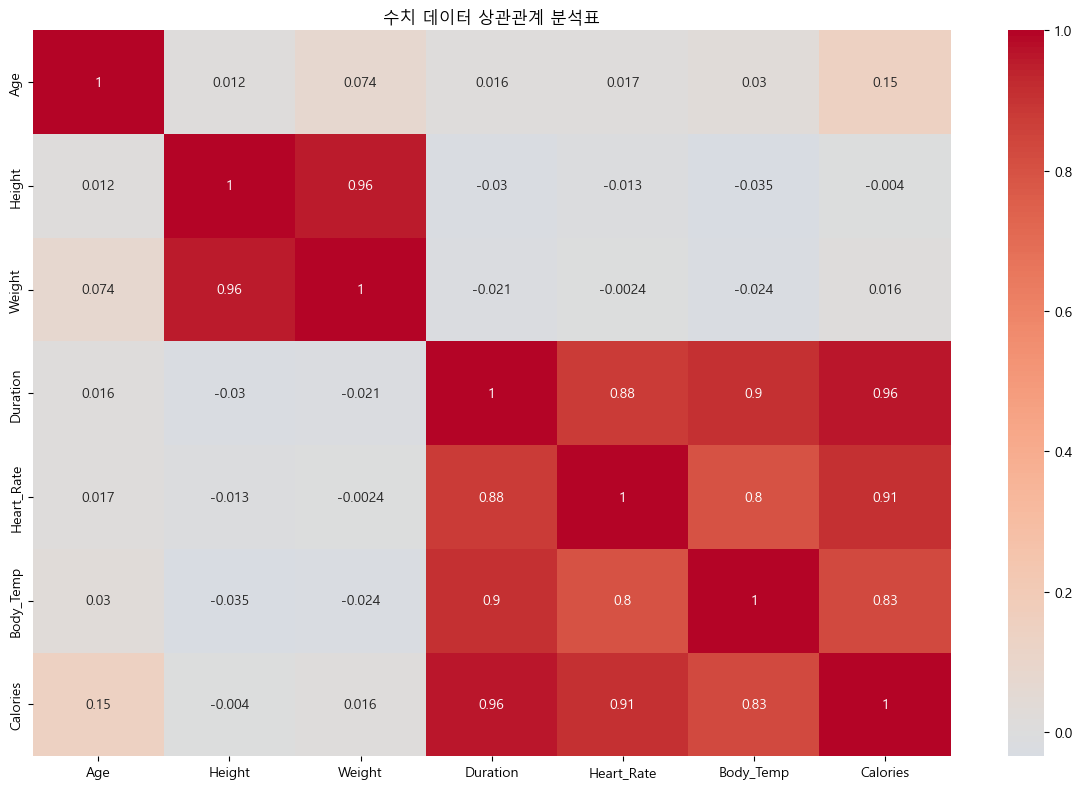

In [10]:
# 상관관계 히트맵
correlation_matrix = train2[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('수치 데이터 상관관계 분석표')
plt.tight_layout()
plt.show()

In [11]:
# 상관계수 (Target 은 Calories, y축, 나머지 변수들은 x축)
# 계수가 0에 가까우면 두 변수는 서로 상관관계가 없다
# 계수가 +/- 1에 가까우면 두 변수는 서로 상관관계가 강해진다.
correlation_matrix['Calories'].sort_values(ascending=False)

Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64

# 이변량 분석

C:\Users\Admin\AppData\Local\Temp\ipykernel_23336\2555405687.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Admin\Desktop\ai_statistics\playground-series-s5e5\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


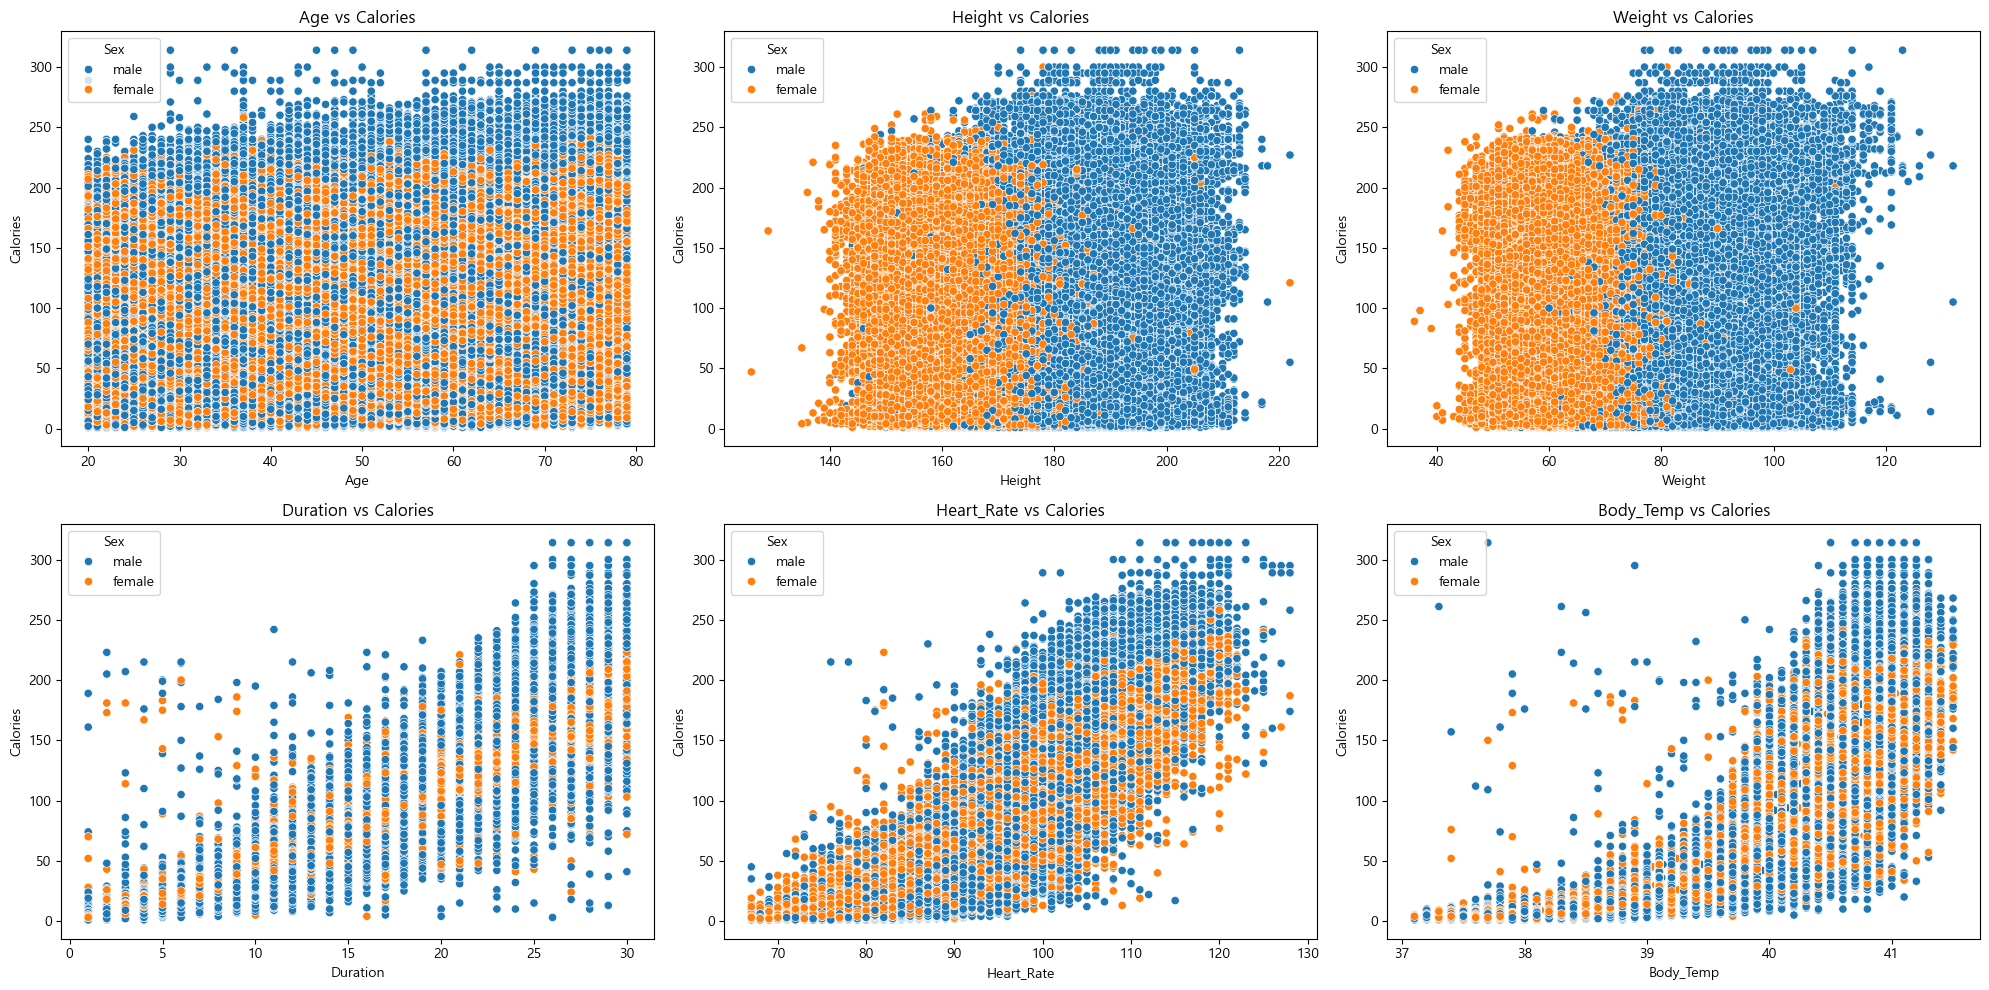

In [12]:
# # Calories ~ Duration (성별)
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.scatterplot(data=train2, x='Duration', y='Calories', hue='Sex', ax=ax)
# plt.show()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.ravel() 

for i, col in enumerate(numeric_cols):
    if col != 'Calories':
        sns.scatterplot(data=train2, x=col, y = 'Calories', hue='Sex', ax=axes[i])
        axes[i].set_title(f'{col} vs Calories')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Calories')

plt.tight_layout()
plt.show()

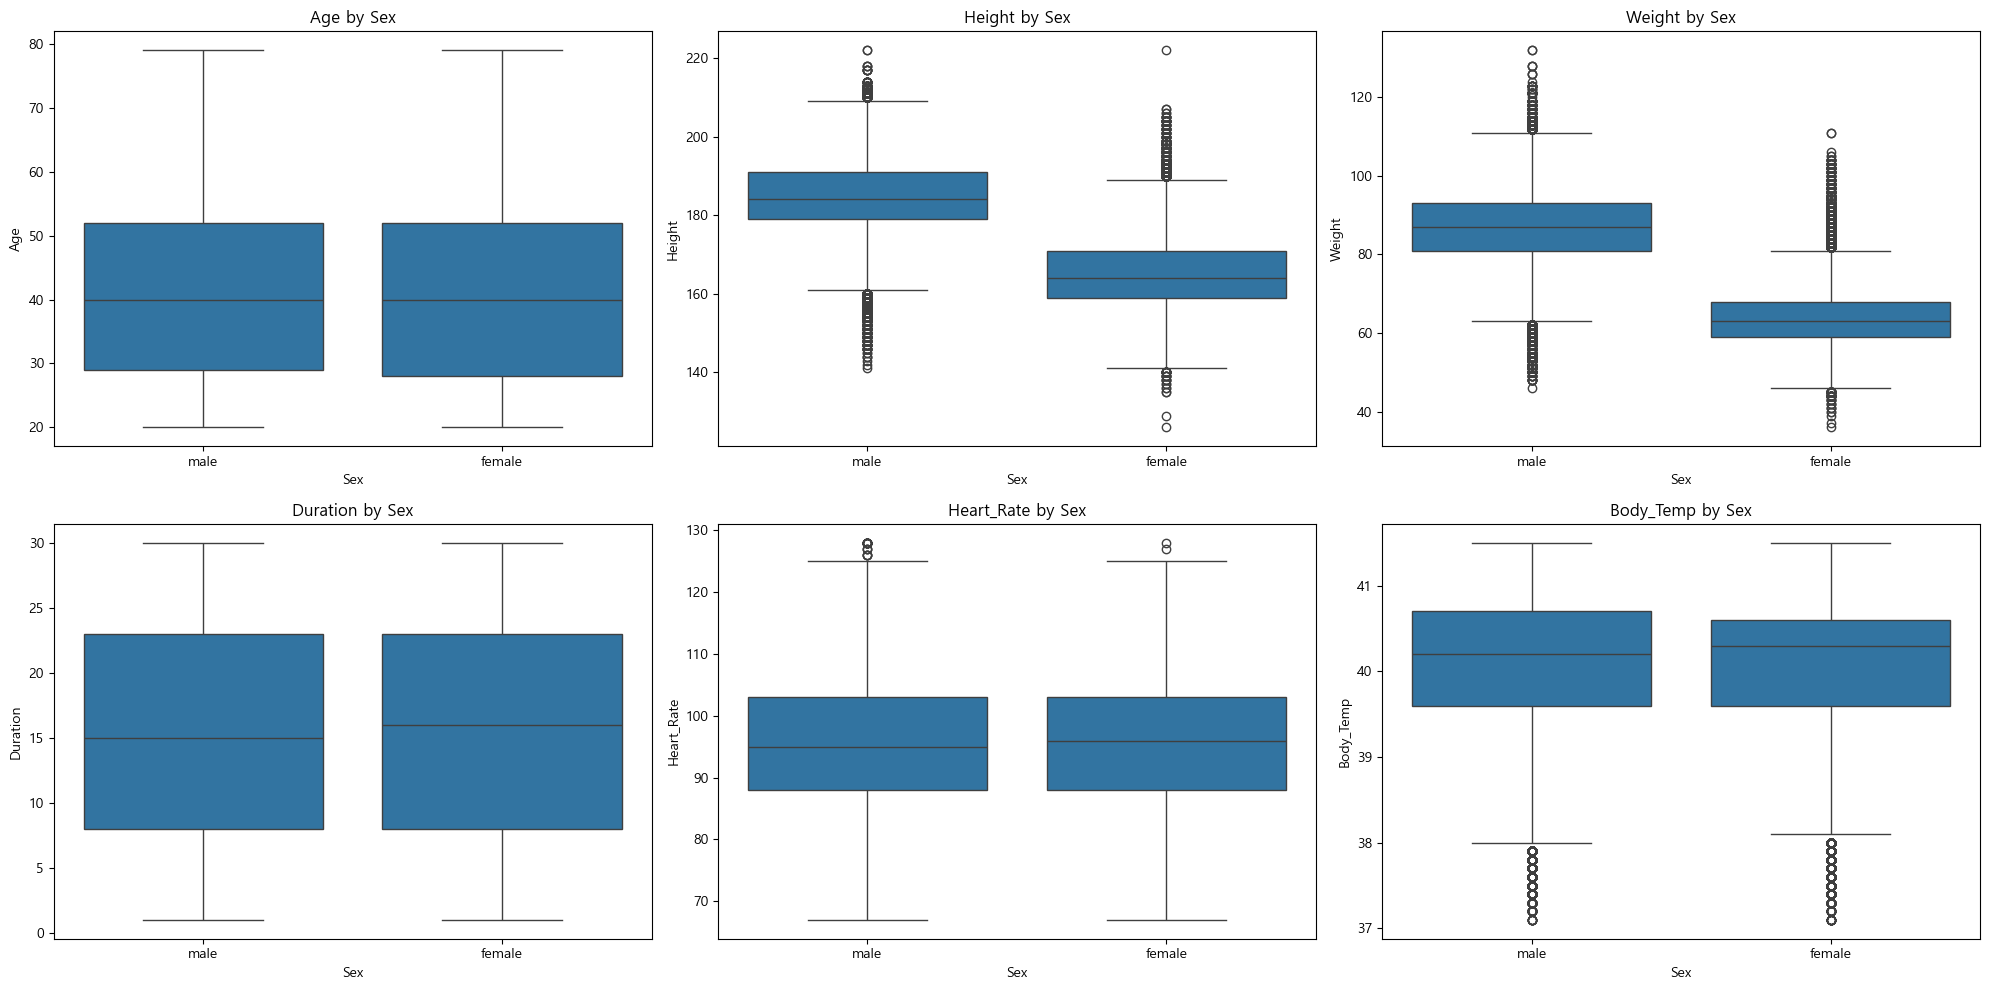

In [13]:
# 박스플롯으로 성별에 따른 각 변수의 분포 확인 (2x4 형태)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    if col != 'Calories':
        sns.boxplot(data=train2, x='Sex', y=col, ax=axes[idx])
        axes[idx].set_title(f'{col} by Sex')

plt.tight_layout()
plt.show()

## 카이제곱 검정 (독립성 검정)
- 적합도 검정, 독립성 검정
- 성별과 운동지속시간(Duration) 간의 상관관계 분석
  + 운동지속시간의 범주를 좁혀보자. (0~30분)
  + 구간화

In [14]:
train2['Duration_cat'] = pd.cut(
    train2['Duration'],
    bins=[0, 10, 20, 30],
    labels=["0-10분", "10-20분", "20-30분"]
)
train2.info()
train2['Duration_cat'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Sex           750000 non-null  object  
 1   Age           750000 non-null  int64   
 2   Height        750000 non-null  float64 
 3   Weight        750000 non-null  float64 
 4   Duration      750000 non-null  float64 
 5   Heart_Rate    750000 non-null  float64 
 6   Body_Temp     750000 non-null  float64 
 7   Calories      750000 non-null  float64 
 8   Duration_cat  750000 non-null  category
dtypes: category(1), float64(6), int64(1), object(1)
memory usage: 46.5+ MB


Duration_cat
10-20분    259243
0-10분     249481
20-30분    241276
Name: count, dtype: int64

In [15]:
# 교차표 생성
contingency_table = pd.crosstab(train2['Sex'], train2['Duration_cat'])
contingency_table

Duration_cat,0-10분,10-20분,20-30분
Sex,,,
female,121189,134407,120125
male,128292,124836,121151


- 가설 설정
  + 귀무가설 : 두 변수는 서로 관련 없음 (독립)
  + 대립가설 : 두 변수는 서로 관련 있음 (독립 아님)
- 성별과 운동지속시간은 서로 독립적이지 않다. => 서로 연관관계가 있다.

In [16]:
import scipy.stats
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(chi2, p_value)
print(expected)

557.1748266564341 1.0257078135366766e-121
[[124980.33440133 129870.71893733 120869.94666133]
 [124500.66559867 129372.28106267 120406.05333867]]


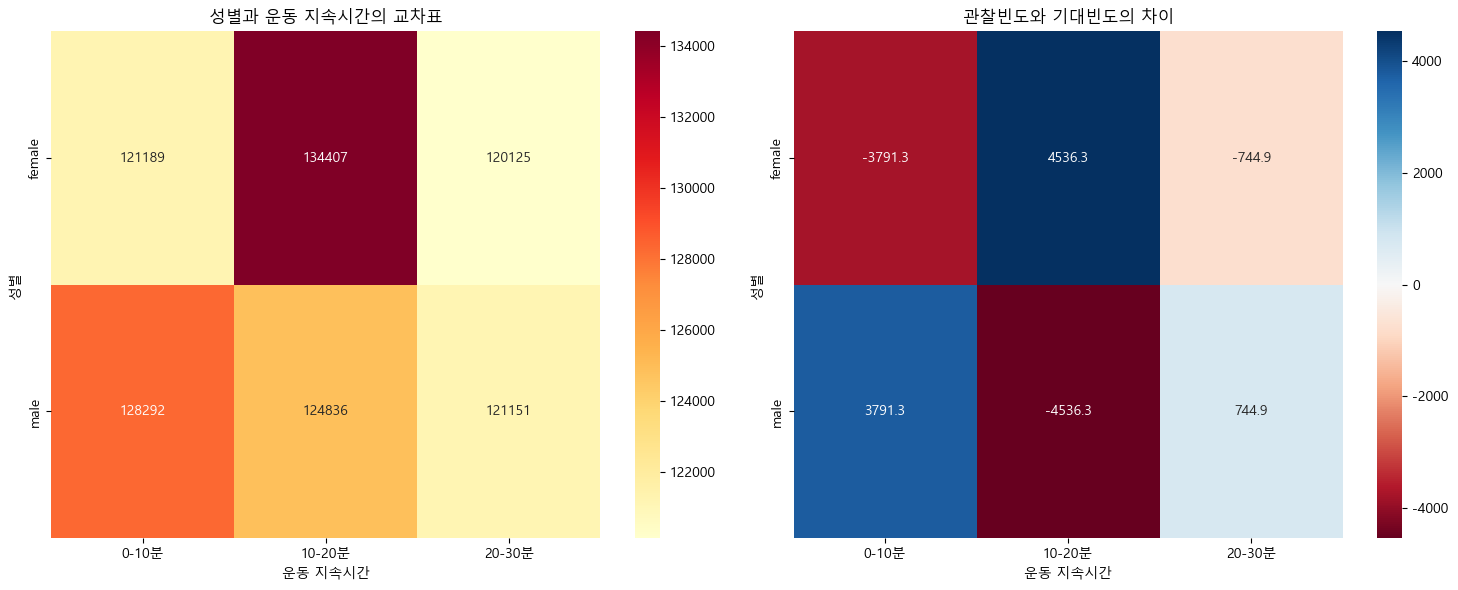

In [17]:
# 교차표 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 관찰빈도 히트맵
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax1)
ax1.set_title('성별과 운동 지속시간의 교차표')
ax1.set_xlabel('운동 지속시간')
ax1.set_ylabel('성별')

# 기대빈도와 관찰빈도의 차이 히트맵
difference = contingency_table - expected
sns.heatmap(difference, annot=True, fmt='.1f', cmap='RdBu', center=0, ax=ax2)
ax2.set_title('관찰빈도와 기대빈도의 차이')
ax2.set_xlabel('운동 지속시간')
ax2.set_ylabel('성별')

plt.tight_layout()
plt.show()

## 회귀분석
- 종속변수가 Calories, 나머지는 모두 독립변수

In [18]:
import statsmodels.api as sm

# 회귀모형을 만들어보세요!! (~35분까지)
# 잔차분석(데이터분석)
train2.head()

# Sex  컬럼 형변환 
train2['Sex'] = train2['Sex'].astype('category')
train3 = train2.drop('Duration', axis=1)

# formula로 생성
features = [col for col in train3.columns if col != 'Calories']
formula = 'Calories ~ ' + ' + '.join(features)
results = sm.OLS.from_formula(formula, data=train3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 1.337e+06
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        10:17:36   Log-Likelihood:            -3.1423e+06
No. Observations:              750000   AIC:                         6.285e+06
Df Residuals:                  749991   BIC:                         6.285e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -741

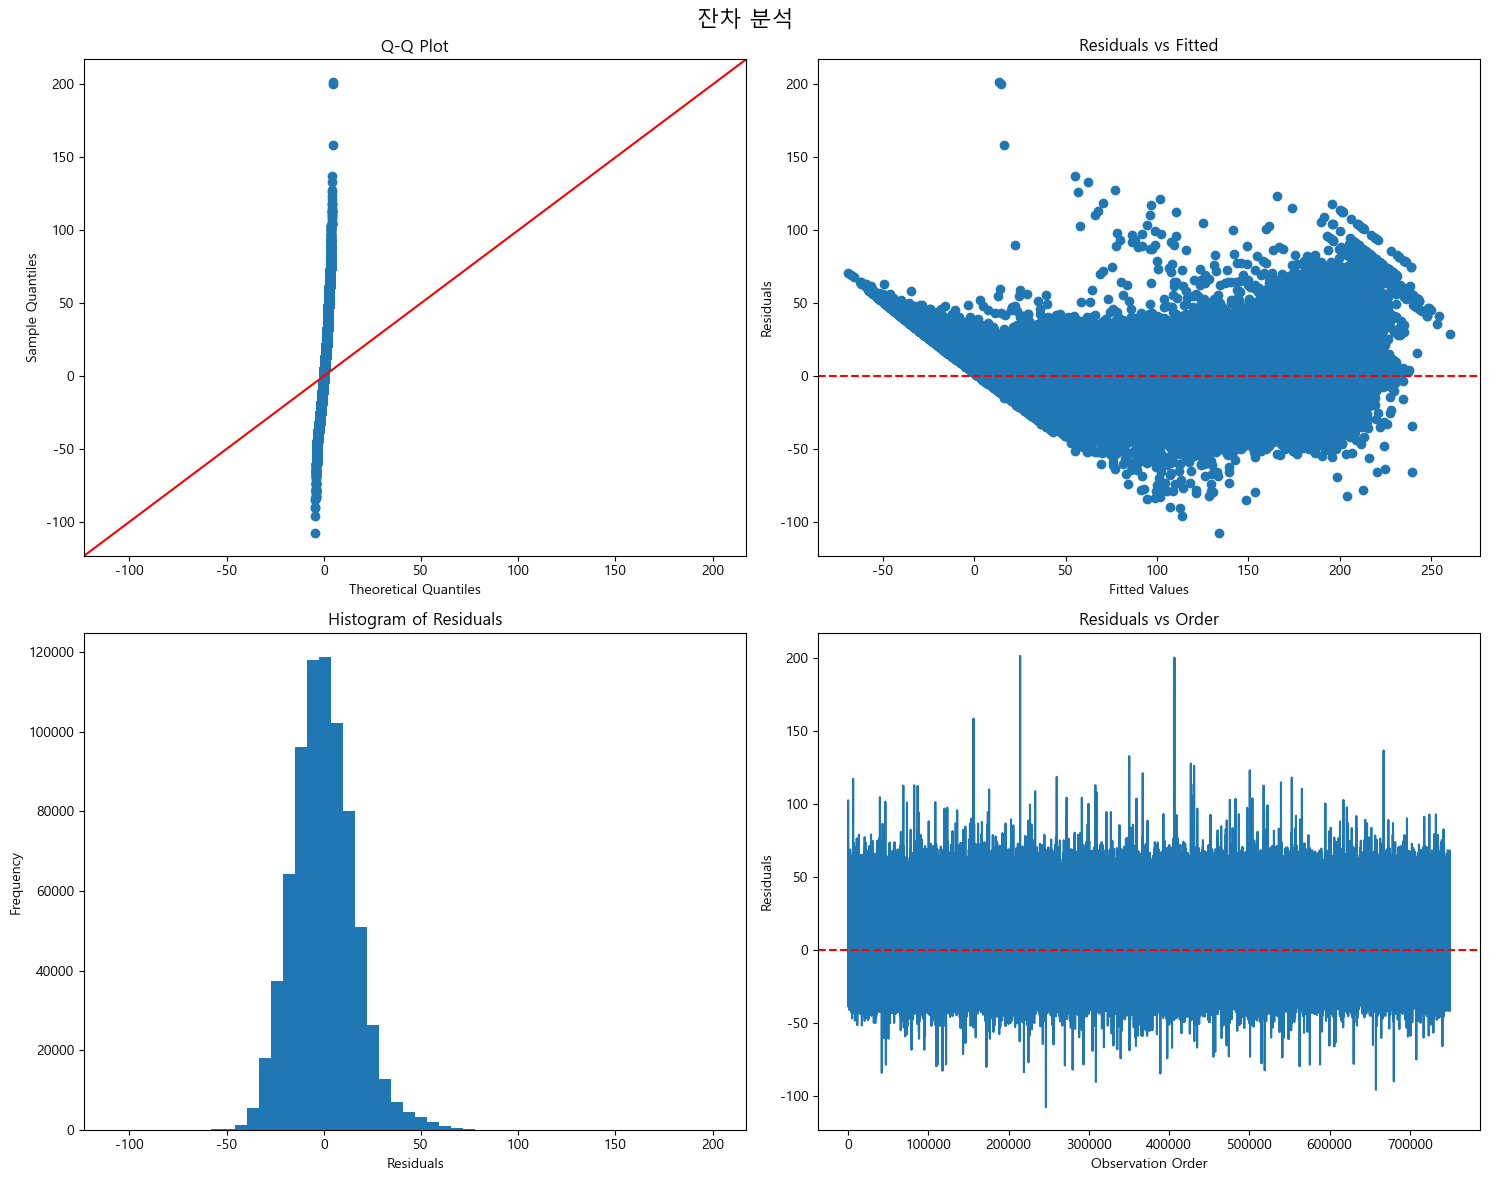

C:\Users\Admin\Desktop\ai_statistics\playground-series-s5e5\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 750000.
  res = hypotest_fun_out(*samples, **kwds)



Shapiro-Wilk 정규성 검정 결과:
통계량: 0.9870
p-value: 0.0000

Breusch-Pagan 등분산성 검정 결과:
통계량: 91139.4914
p-value: 0.0000

Durbin-Watson 자기상관성 검정 결과:
통계량: 2.0005


In [19]:
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 잔차 분석을 위한 데이터 준비
residuals = results.resid
fitted_values = results.fittedvalues

# 잔차 분석을 위한 그래프 생성
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('잔차 분석', fontsize=16)

# 1. 잔차의 정규성 검정 (Q-Q plot)
sm.qqplot(residuals, line='45', ax=axes[0,0])
axes[0,0].set_title('Q-Q Plot')

# 2. 잔차의 등분산성 검정 (Residuals vs Fitted)
axes[0,1].scatter(fitted_values, residuals)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Fitted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals vs Fitted')

# 3. 잔차의 히스토그램
axes[1,0].hist(residuals, bins=50)
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Histogram of Residuals')

# 4. 잔차의 자기상관성 검정 (Residuals vs Order)
axes[1,1].plot(residuals)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Observation Order')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs Order')

plt.tight_layout()
plt.show()

# 정규성 검정 (Shapiro-Wilk test)
shapiro_test = stats.shapiro(residuals)
print("\nShapiro-Wilk 정규성 검정 결과:")
print(f"통계량: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.4f}")

# 등분산성 검정 (Breusch-Pagan test)
bp_test = het_breuschpagan(residuals, results.model.exog)
print("\nBreusch-Pagan 등분산성 검정 결과:")
print(f"통계량: {bp_test[0]:.4f}")
print(f"p-value: {bp_test[1]:.4f}")

# 자기상관성 검정 (Durbin-Watson test)
dw_test = durbin_watson(residuals)
print("\nDurbin-Watson 자기상관성 검정 결과:")
print(f"통계량: {dw_test:.4f}")

### 통계적 관점에서의 회귀
- 기존에 만든 모델은 사용 불가 (이유: 회귀식 전제(가정) 만족시키지 못함)
- 해결방안
  + 첫번째 방법 : 종속변수(Target)을 로그변환
  + 두번째 방법 : 독립변수(수치 데이터만) 모두를 표준화해야함
  + 세번째 방법 : 로그변환 + 표준화
  + 네번째 방법 : 특정 변수에서 0이 많이 존재하는지 확인 ==> 별도로 처리(옵션 많음, 범주화, 버릴 것인지)
  + 다섯번째 방법 : 독립변수 별도로 재선별(다중공산성)
  + 그 외... ==> 알고리즘 변경(회귀식의, 릿지, 라쏘, 그 외 등등..)
- ML/DL 회귀 : 통계 검정 다 고려 안함, 예측만 잘하면 뭐든지 OK